# PRACTICE: MNIST
*This is a notebook about classification*

## SETUP

In [15]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter3_classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 1. LOOK AT THE BIG PICTURE
*(performance measure, frame the problem, etc.)*

## 2. GET THE DATA

### Dowload the Data

In [6]:
# Fetch data (sklearn)
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**Evaluate:** Datasets loaded by Sklearn generally have a similiar dictionary structure (`as_frame=False`) including:
- A `DESCR` key describes the dataset
- A `data` key
- A `target` key

### Take a Quick Look at the Data Structure

In [7]:
# Inspect the shape (1)
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [8]:
# Inspect the shape (2)
y.shape

(70000,)

**Evaluate:** There are 70,000 images; each image has 784 features (28x28 pixels)

Saving figure some_digit_plot


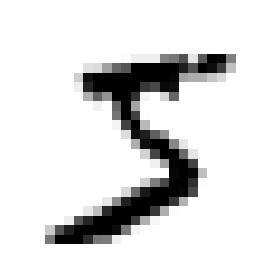

In [9]:
# Take a peek at one digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')

save_fig("some_digit_plot")
plt.show()

In [10]:
# What is its label?
y[0]

'5'

**Evaluate:** The label is string, so y will be casted to integers.

In [11]:
# Cast the labels to integers
y = y.astype(np.uint8)

### Create a Test Set

**Evaluate:** The MNIST dataset is already split into a training set (60,000 img) and a test set (10,000 img). (also shuffled)

In [14]:
# Create test and training set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] # Numpy array
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## TRAINING A BINARY CLASSIFIER

**Evaluate:** Instead of the identification for digits, the problem is simlified to identify just 1 digit (eg. 5), which is called binary classifier.

In [19]:
# Create the target vectors for 5-classification task
y_train_5 = (y_train == 5) # True for all 5s, False otherwise
y_test_5 = (y_test == 5)

In [20]:
# Train SGD model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [21]:
# Predict whether the former record is the number 5 using SGD model
sgd_clf.predict([some_digit])

array([ True])

**Evaluate:** Guess right!

## PERFORMANCE MEASURES

**Remark:** Evaluating a classifier is often significantly trickier than evaluating a regressor, which is worth pages.

### Measuring Accuracy Using Cross-Validation

In [23]:
# Implementing cross-validation (fuction like cross_val_score() in sklearn)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [24]:
# K-fold cross validation on the model (sklearn)
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

**Evaluate:** Above 90% accuracy on all folds? An insight in "not-5" images is needed.

In [25]:
# Setup a classifier that classifies every image in the "not-5" class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [26]:
# K-fold cross validation on the custom model
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

**Evaluate:** This dumb model has over 90% accuracy. The reason is that only 10% of the images are 5s, which means guessing an image "not-5" will be right about 90% of the time => Accuracy is not preferred measure for classifier (at least with this dataset).

### Confusion Matrix